In [1]:
# Step 1: Generate Images and Masks from FLAIR
# ---------------------------------------------
import os
import numpy as np
import pydicom
import cv2
from tqdm import tqdm
from PIL import Image

input_base = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"
output_image_dir = "./images"
output_mask_dir = "./masks"
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

def normalize_img(img):
    img = img.astype(np.float32)
    img -= img.min()
    if img.max() != 0:
        img /= img.max()
    img *= 255.0
    return img.astype(np.uint8)

def generate_mask(img, thresh=140):
    _, mask = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)
    return mask

print("Generating image/mask pairs from FLAIR scans...")
for patient_id in tqdm(os.listdir(input_base)):
    flair_path = os.path.join(input_base, patient_id, "FLAIR")
    if not os.path.exists(flair_path):
        continue
    
    for file in sorted(os.listdir(flair_path)):
        dcm_path = os.path.join(flair_path, file)
        try:
            dcm = pydicom.dcmread(dcm_path)
            img = dcm.pixel_array
            img = normalize_img(img)
            img_resized = cv2.resize(img, (128, 128))
            mask = generate_mask(img_resized)

            base_filename = f"{patient_id}_{file.replace('.dcm', '')}.png"
            Image.fromarray(img_resized).save(os.path.join(output_image_dir, base_filename))
            Image.fromarray(mask).save(os.path.join(output_mask_dir, base_filename))
        except Exception as e:
            print(f"Error processing {dcm_path}: {e}")
            continue


Generating image/mask pairs from FLAIR scans...


100%|██████████| 585/585 [20:50<00:00,  2.14s/it]


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, image_filenames, image_dir, mask_dir, transform=None):
        self.image_filenames = image_filenames
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            mask = (mask > 0).float()  # Binary

        return image, mask

# Prepare file list
all_images = os.listdir("./images")
train_val_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_val_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_images)}, Validation: {len(val_images)}, Test: {len(test_images)}")

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Datasets
train_dataset = BrainTumorSegmentationDataset(train_images, "./images", "./masks", transform)
val_dataset = BrainTumorSegmentationDataset(val_images, "./images", "./masks", transform)
test_dataset = BrainTumorSegmentationDataset(test_images, "./images", "./masks", transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


Train: 47518, Validation: 11880, Test: 14850


In [12]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.middle = CBR(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.up4(m)
        d4 = torch.cat([e4, d4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([e3, d3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([e2, d2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([e1, d1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        out = torch.sigmoid(out)
        return out


In [13]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 15
train_losses = []
val_losses = []
best_val_loss = float('inf')
save_path = "best_model.pth"

for epoch in range(epochs):
    model.train()
    train_epoch_loss = 0
    for img, mask in tqdm(train_loader):
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        loss = criterion(output, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()
    avg_train_loss = train_epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_epoch_loss = 0 
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)
            output = model(img)
            loss = criterion(output, mask)
            val_epoch_loss += loss.item()
    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f" Saved Best Model at Epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")


100%|██████████| 11880/11880 [08:02<00:00, 24.62it/s]


Epoch 1/15 - Train Loss: 0.0061 | Val Loss: 0.0021
 Saved Best Model at Epoch 1 with Val Loss: 0.0021


100%|██████████| 11880/11880 [07:50<00:00, 25.24it/s]


Epoch 2/15 - Train Loss: 0.0007 | Val Loss: 0.0003
 Saved Best Model at Epoch 2 with Val Loss: 0.0003


100%|██████████| 11880/11880 [07:50<00:00, 25.26it/s]


Epoch 3/15 - Train Loss: 0.0005 | Val Loss: 0.0002
 Saved Best Model at Epoch 3 with Val Loss: 0.0002


100%|██████████| 11880/11880 [07:50<00:00, 25.24it/s]


Epoch 4/15 - Train Loss: 0.0004 | Val Loss: 0.0002
 Saved Best Model at Epoch 4 with Val Loss: 0.0002


100%|██████████| 11880/11880 [07:51<00:00, 25.21it/s]


Epoch 5/15 - Train Loss: 0.0004 | Val Loss: 0.0002


100%|██████████| 11880/11880 [07:51<00:00, 25.22it/s]


Epoch 6/15 - Train Loss: 0.0005 | Val Loss: 0.0001
 Saved Best Model at Epoch 6 with Val Loss: 0.0001


100%|██████████| 11880/11880 [07:50<00:00, 25.23it/s]


Epoch 7/15 - Train Loss: 0.0004 | Val Loss: 0.0001


100%|██████████| 11880/11880 [07:50<00:00, 25.23it/s]


Epoch 8/15 - Train Loss: 0.0002 | Val Loss: 0.0001
 Saved Best Model at Epoch 8 with Val Loss: 0.0001


100%|██████████| 11880/11880 [07:50<00:00, 25.23it/s]


Epoch 9/15 - Train Loss: 0.0003 | Val Loss: 0.0001
 Saved Best Model at Epoch 9 with Val Loss: 0.0001


100%|██████████| 11880/11880 [07:50<00:00, 25.24it/s]


Epoch 10/15 - Train Loss: 0.0003 | Val Loss: 0.0001
 Saved Best Model at Epoch 10 with Val Loss: 0.0001


100%|██████████| 11880/11880 [07:50<00:00, 25.25it/s]


Epoch 11/15 - Train Loss: 0.0003 | Val Loss: 0.0001
 Saved Best Model at Epoch 11 with Val Loss: 0.0001


100%|██████████| 11880/11880 [07:49<00:00, 25.30it/s]


Epoch 12/15 - Train Loss: 0.0004 | Val Loss: 0.0000
 Saved Best Model at Epoch 12 with Val Loss: 0.0000


100%|██████████| 11880/11880 [07:49<00:00, 25.29it/s]


Epoch 13/15 - Train Loss: 0.0002 | Val Loss: 0.0000
 Saved Best Model at Epoch 13 with Val Loss: 0.0000


100%|██████████| 11880/11880 [07:49<00:00, 25.29it/s]


Epoch 14/15 - Train Loss: 0.0003 | Val Loss: 0.0001


100%|██████████| 11880/11880 [07:49<00:00, 25.30it/s]


Epoch 15/15 - Train Loss: 0.0004 | Val Loss: 0.0000


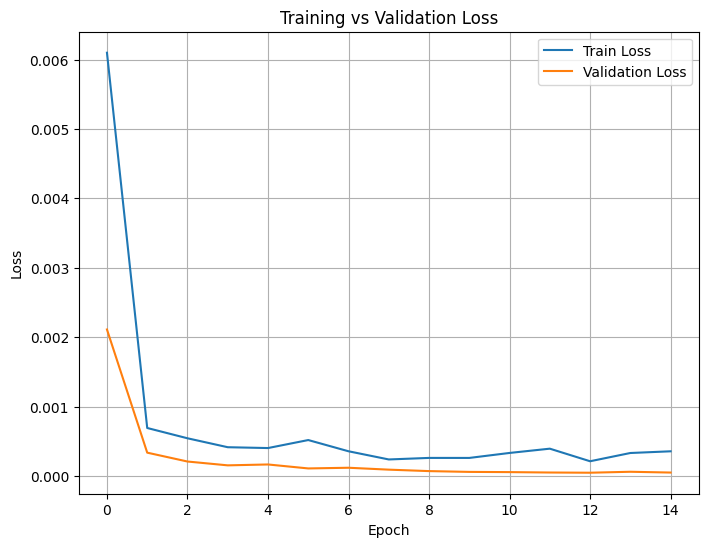

In [14]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
import torch
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            outputs = (outputs > 0.5).float()  # Binarize output

            # Flatten for metric calculation
            outputs_flat = outputs.view(-1)
            masks_flat = masks.view(-1)

            # Dice Score
            intersection = (outputs_flat * masks_flat).sum()
            dice = (2. * intersection) / (outputs_flat.sum() + masks_flat.sum() + 1e-8)
            dice_scores.append(dice.item())

            # IoU Score
            union = outputs_flat.sum() + masks_flat.sum() - intersection
            iou = intersection / (union + 1e-8)
            iou_scores.append(iou.item())

    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)

    print(f"\nEvaluation on Test Set:")
    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score : {avg_iou:.4f}")

    return avg_dice, avg_iou


In [22]:
evaluate_model(model, test_loader, device)



Evaluation on Test Set:
Average Dice Score: 0.9928
Average IoU Score : 0.9926


(0.9928006855362097, 0.992608195233467)

In [28]:
import random
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    test_batch = next(iter(test_loader))
    images, masks = test_batch
    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images)
    outputs = (outputs > 0.5).float()

    for i in range(num_samples):
        idx = random.randint(0, images.shape[0] - 1)
        img = images[idx].cpu().squeeze().numpy()
        mask_true = masks[idx].cpu().squeeze().numpy()
        mask_pred = outputs[idx].cpu().squeeze().numpy()

        fig, axs = plt.subplots(1, 3, figsize=(15,5))

        # Show input image (still in grayscale because FLAIR is grayscale)
        axs[0].imshow(img, cmap='gray')
        axs[0].set_title('Input Image')

        # For mask_true and mask_pred, use 'jet' colormap for colors
        axs[1].imshow(mask_true, cmap='jet', alpha=0.7)   # Ground truth mask
        axs[1].set_title('Ground Truth Mask (Color)')

        axs[2].imshow(mask_pred, cmap='jet', alpha=0.7)   # Predicted mask
        axs[2].set_title('Predicted Mask (Color)')

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()


/tmp/ipykernel_31/3827822264.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


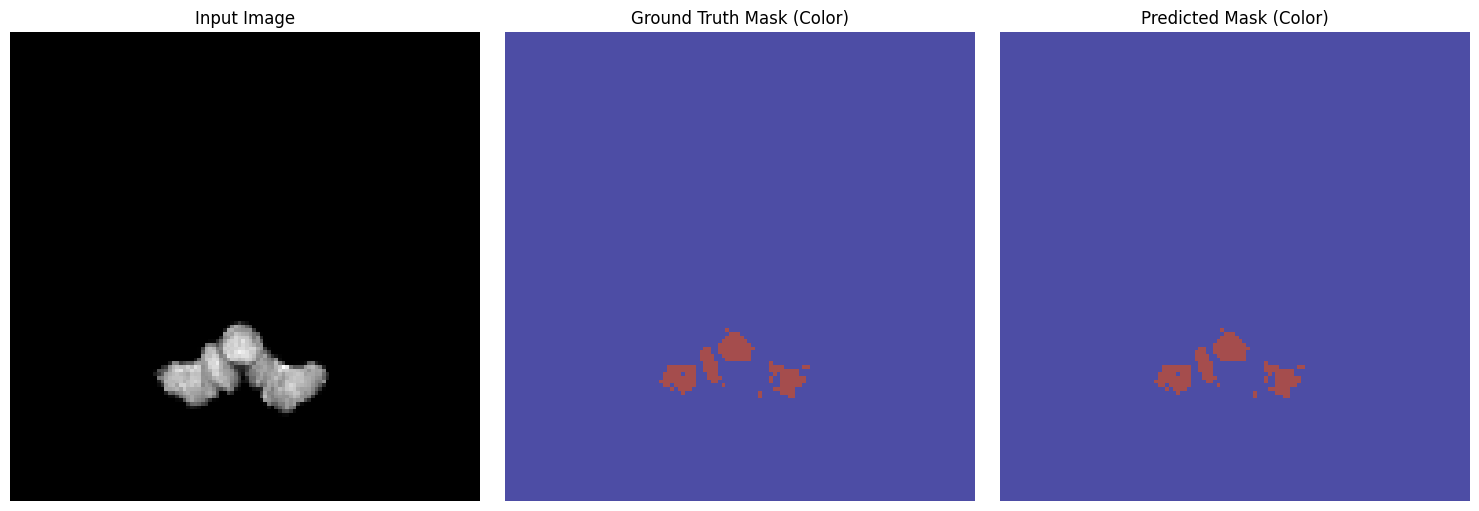

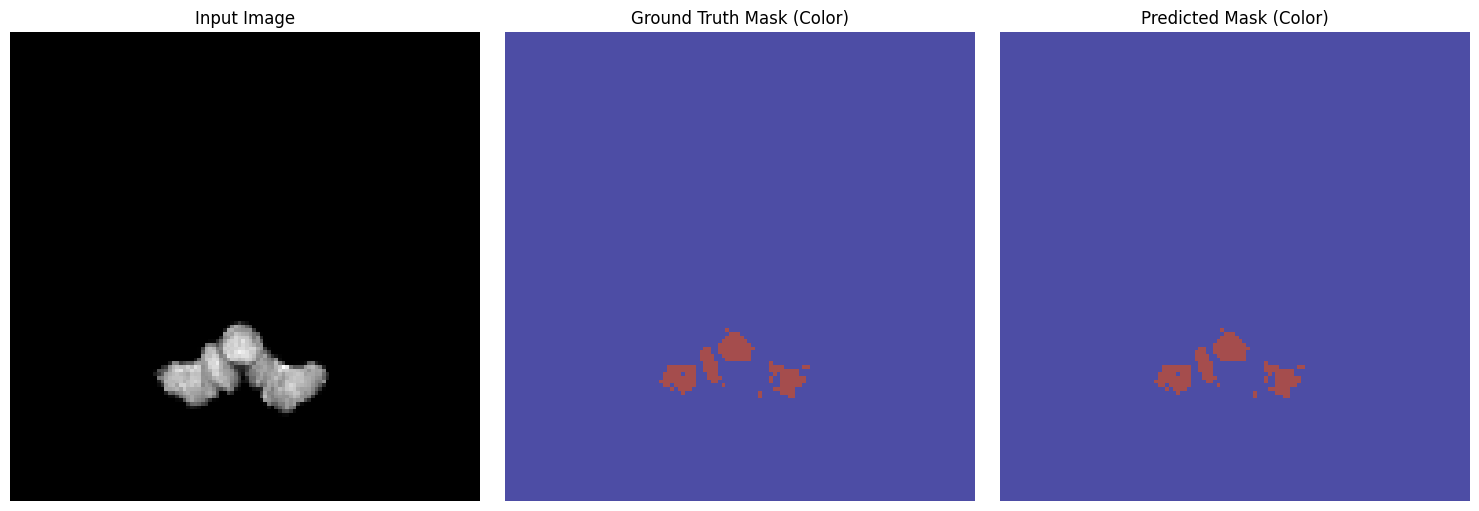

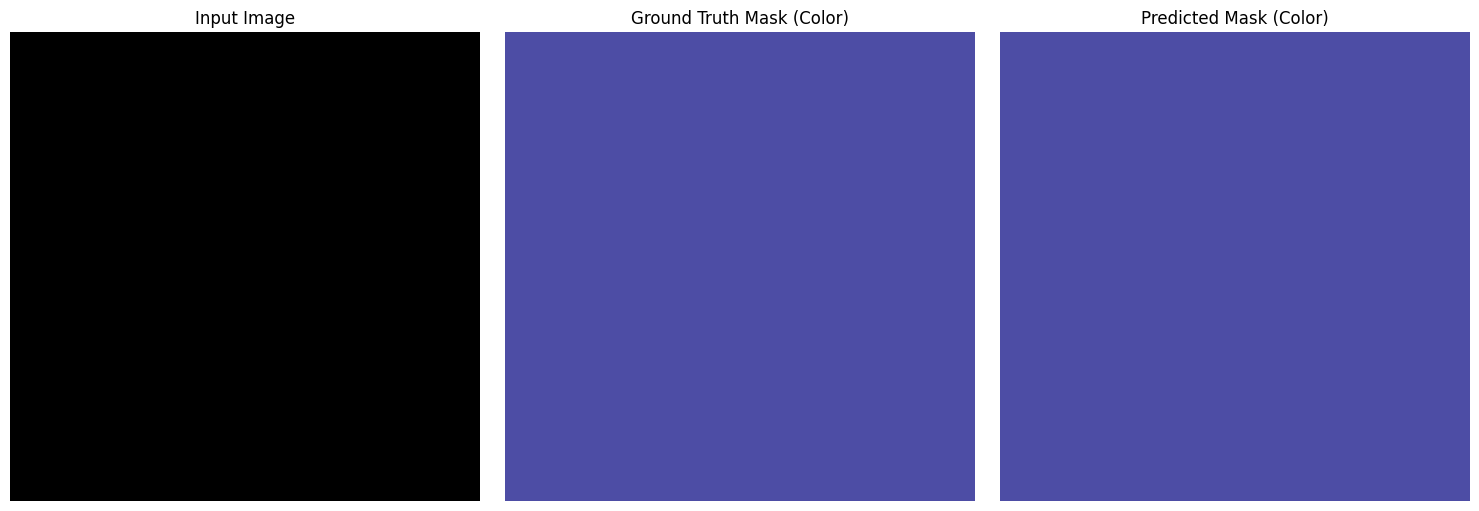

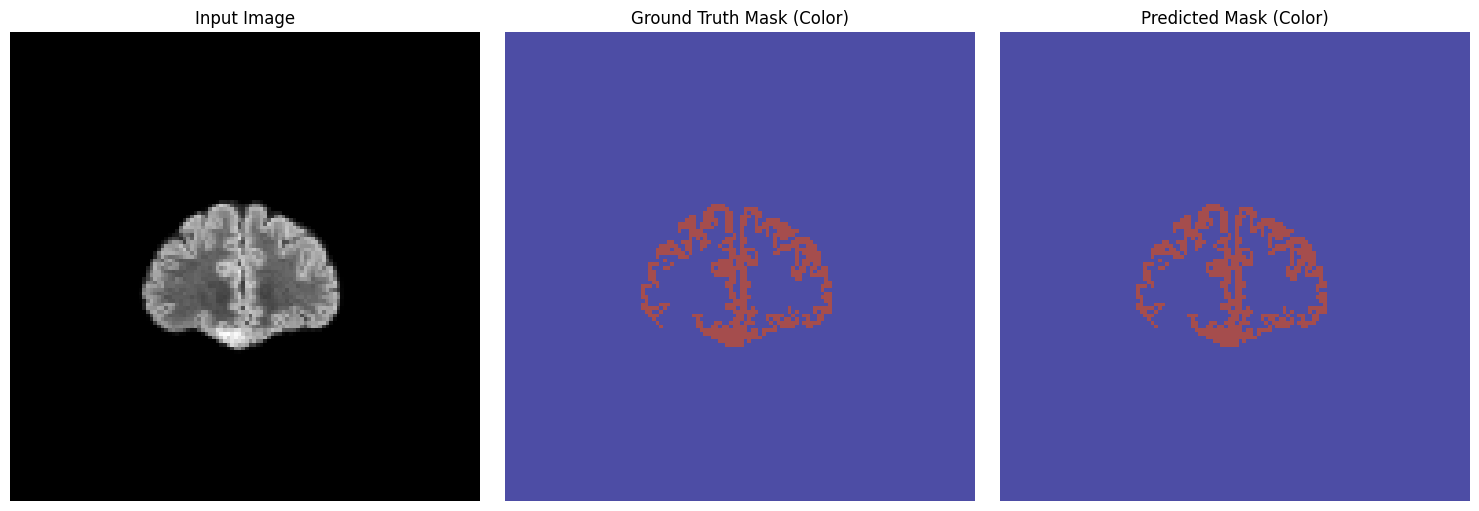

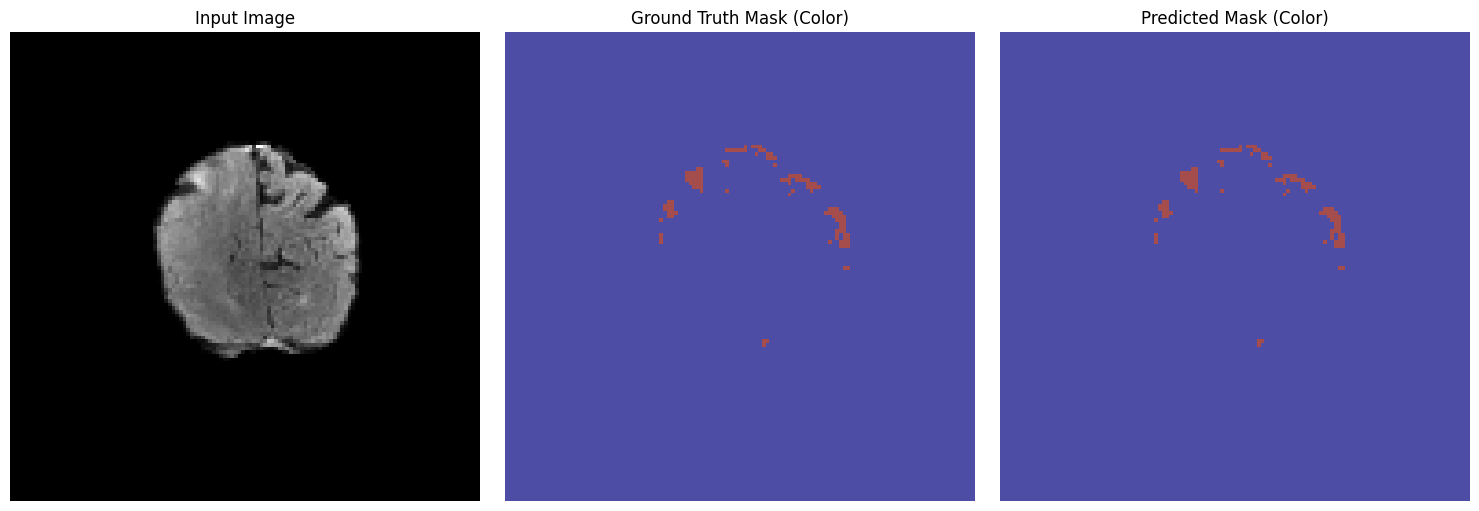

In [29]:
# Load Best Model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Visualize random test samples
visualize_predictions(model, test_loader, num_samples=5)

 
